# NMS

In [14]:
import numpy as np
def non_max_suppression_slow(boxes, overlapThresh):
	if len(boxes) == 0:
		return []
	pick = []
  # Tìm tọa độ của điểm trên cùng bên trái và điểm dưới cùng bên phải  của từng box 
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,0]+boxes[:,2]
	y2 = boxes[:,1]+boxes[:,3]
  # Tìm diện tích của  box
	area = (x2 - x1 ) * (y2 - y1 )
 # Để lấy các chỉ mục của tọa độ đã sắp xếp của tọa độ y dưới cùng bên phải của các hộp giới hạn. 
	idxs = np.argsort(y2)
 #Returns the indices that would sort an array.
	while len(idxs) > 0:
    # lấy box để xét
		last = len(idxs) - 1
		i = idxs[last]
    # cho box vào tập keep
		pick.append(i)
  #  loại  box ra khoỉ tập P
		suppress = [last]
		for pos in range(0, last):
			j = idxs[pos]
      # Tìm tọa đọ của vùng giao nhau (Intersection)
			xx1 = max(x1[i], x1[j])
			yy1 = max(y1[i], y1[j])
			xx2 = min(x2[i], x2[j])
			yy2 = min(y2[i], y2[j])
      # Tìm tọa đọ của vùng giao nhau (Intersection)
			w = max(0, xx2 - xx1 )
			h = max(0, yy2 - yy1 )
			# Tinhs iou
			overlap = float(w * h) / area[j]
			# Nếu có box nào trong P có IOU với box S đang xét mà lớn hơn ngưỡng thresh_iou thì loại bỏ box đó ra khỏi P
			if overlap > overlapThresh:
				suppress.append(pos)
		idxs = np.delete(idxs, suppress)
	return boxes[pick]

In [3]:
import cv2
ref_img = cv2.imread('object.png')
ref_img.shape[0:2]


(260, 296)

In [6]:
tar_img = cv2.imread('gốc.png')
tar_img.shape[1]

432

# THực hiện Sliding Windows and Homography

In [52]:
import cv2
import numpy as np
import time
# Load the two images
ref_img = cv2.imread('object.png')
tar_img = cv2.imread('gốc.png')
import imutils
#pyramid image 
def pyramid(image, scale=244/260, minSize=(30, 30)):
	yield image
	while True:
		# resize ảnh
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		yield image

def sliding_window(image, stepSize, windowSize):
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
(winW, winH) = (260, 296)
l = [ ]
i = 0 
%matplotlib inline
for resized in pyramid(tar_img, scale=244/260):
  i += 1
  if i == 10:
    break
  # loop over the sliding window for each layer of the pyramid
  for (x, y, window) in sliding_window(resized, stepSize=20, windowSize=(winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
      continue

    sift = cv2.xfeatures2d.SIFT_create()
  
    keypoints_ref, descriptors_ref = sift.detectAndCompute(ref_img, None)
    keypoints_tar, descriptors_tar = sift.detectAndCompute(window, None)
    # Match the keypoints between the two images
    try:
      bf = cv2.BFMatcher()
      matches = bf.knnMatch(descriptors_ref, descriptors_tar, k=2)

      # Calculate the homography matrix
      good = []
      try:
        for m, n in matches:
            if m.distance < 0.9 * n.distance:
                good.append(m)
      # Không tìm thấy đối tượng 
      except ValueError:
        pass
      if len(good) > 37:
          src_pts = np.float32([keypoints_ref[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
          dst_pts = np.float32([keypoints_tar[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
          M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
          # Lấy các điểm 4 góc 
          h, w = ref_img.shape[0],ref_img.shape[1]
          pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
          # Thực hiện Biến đổi phối cảnh
          dst = cv2.perspectiveTransform(pts, M)
          # Vẽ bounding box 
          l.append(dst)
      else:
          pass
    # Nếu không tìm thấy matches thì bỏ qua
    except Exception as e:
        # Handle the error here
        pass


# Lấy ra các box có good matches

In [53]:
# Get the first and third value of the array 

def get_first_and_third_values(l):
    arr = np.int32(l)
    return [arr[0][0][0], arr[0][0][1],arr[2][0][0], arr[2][0][1]]

In [54]:
k =get_first_and_third_values(l[0])
k

[-5, 1, 249, 221]

In [55]:
k

[-5, 1, 249, 221]

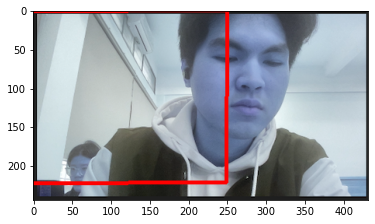

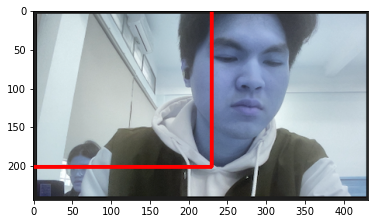

In [57]:
import matplotlib.pyplot as plt
for i in l:
  plt.imshow(cv2.polylines(cv2.imread('gốc.png'), [np.int32(i)], True, (255, 0, 0), 3))
  plt.show()


In [41]:
box = []
for i in l:
    box.append(get_first_and_third_values(i))
box = np.array(box)
box

array([[ 127,   17,  338,  200],
       [ 106,   14,  314,  199],
       [  87,   16,  297,  200],
       [  67,   16,  277,  200],
       [  46,   16,  257,  200],
       [  26,   16,  237,  200],
       [   6,   16,  217,  200],
       [ -12,   17,  197,  201],
       [ -24,   23,  183,  206],
       [ -51,   16,  157,  201],
       [ 101,   17,  325,  213],
       [  82,   18,  306,  213],
       [  61,   17,  286,  213],
       [  41,   17,  266,  213],
       [  21,   17,  246,  213],
       [   1,   17,  226,  213],
       [ -17,   19,  206,  213],
       [ -38,   15,  185,  214],
       [ -47,   25,  172,  219],
       [ -67,   25,  152,  219],
       [  82,   -2,  306,  193],
       [  62,   -2,  286,  193],
       [  42,   -1,  266,  193],
       [  22,   -1,  246,  193],
       [   2,   -1,  226,  193],
       [ -17,    0,  206,  193],
       [ -37,   -3,  186,  194],
       [ -47,    4,  171,  199],
       [ -67,    4,  151,  199],
       [ 138,   19,  360,  214],
       [  

In [42]:

detections = non_max_suppression_slow(np.array(box), 0)
detections

array([[ 123,  222,  126,  236],
       [-107,   57,  134,  265],
       [  73,    0,  327,  221]], dtype=int32)

# Print Kết Quả

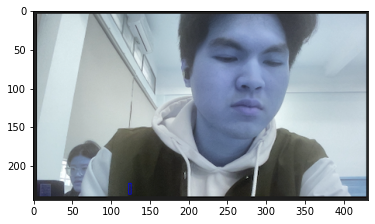

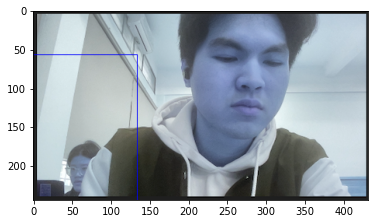

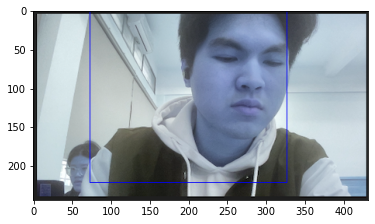

In [43]:
# Display the results 
for (x_tl, y_tl,  w, h) in detections:
    plt.imshow(cv2.rectangle(cv2.imread('gốc.png'), (x_tl, y_tl), (w,h), (0, 0, 255)))
    plt.show()